# **DATA LOADING AND NORMALIZATION**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torchmetrics
!pip install torchsummary

In [4]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

import torch
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score
from torchsummary import summary
import math

In [5]:
from tqdm import tqdm
labels = ['NORMAL', 'PNEUMONIA']
img_size = 224


def get_training_data(data_dir):
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        #print(path)
        class_num = labels.index(label)

        imgs = os.listdir(path)
        for img in tqdm(imgs):
            try:
                # Load and resize the image
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize the image

                # Add the image and label as a pair
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")


    # Convert the list to a NumPy array
    data = np.array(data, dtype=object)  # Use dtype=object to allow image-label pairing
    return data

# Load the data
train_data = get_training_data('/Users/dangerdani/Documents/FKAN-Biostatistics/normData/train')
test_data = get_training_data('/Users/dangerdani/Documents/FKAN-Biostatistics/normData/test')
val_data = get_training_data( '/Users/dangerdani/Documents/FKAN-Biostatistics/normData/val')

100%|██████████| 108/108 [00:00<00:00, 771.29it/s]


## **DATA Preparation**

Count of label 0: 3775
Count of label 1: 3775
Count of label 0: 108
Count of label 1: 108
Shape of train images: (7550, 224, 224)
Shape of validation images: (216, 224, 224)


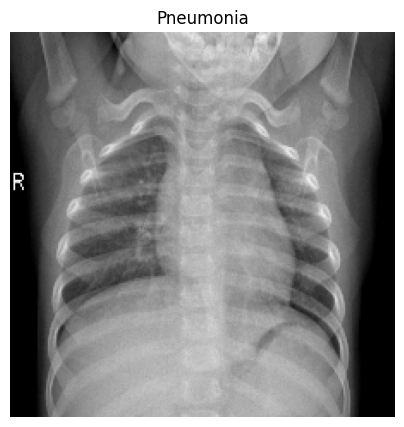

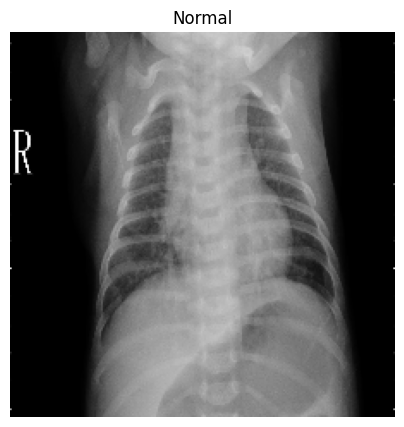

In [ ]:
#Separate the images and the labels
train_images_display = np.array([x[0] for x in train_data])  # Extract only the images
train_labels_display = np.array([x[1] for x in train_data])  # Extract only the labels

# Initialize counts for each label
count_0 = 0
count_1 = 0

# Loop through the labels and count occurrences
for label in train_labels_display:
    if label == 0:
        count_0 += 1
    elif label == 1:
        count_1 += 1

# Print the results
print(f"Count of label 0: {count_0}")
print(f"Count of label 1: {count_1}")

val_images_display = np.array([x[0] for x in val_data])  # Extract only the images
val_labels_display = np.array([x[1] for x in val_data])  # Extract only the labels

count_0 = 0
count_1 = 0

# Loop through the labels and count occurrences
for label in val_labels_display:
    if label == 0:
        count_0 += 1
    elif label == 1:
        count_1 += 1

# Print the results
print(f"Count of label 0: {count_0}")
print(f"Count of label 1: {count_1}")

test_images_display = np.array([x[0] for x in test_data])  # Extract only the images
test_labels_display = np.array([x[1] for x in test_data])  # Extract only the labels

# Check the shape and an example of the dataset
print(f"Shape of train images: {train_images_display.shape}")
print(f"Shape of validation images: {val_images_display.shape}")

# Display the first image from the training data
plt.figure(figsize=(5, 5))
plt.imshow(train_images_display[0], cmap='gray')
plt.title('Pneumonia' if train_labels_display[0] == 0 else 'Normal')
plt.axis('off')
plt.show()

# Display the last image from the validation data
plt.figure(figsize=(5, 5))
plt.imshow(val_images_display[-1], cmap='gray')
plt.title('Pneumonia' if val_labels_display[-1] == 0 else 'Normal')
plt.axis('off')
plt.show()

### Normalize Images

In [6]:
# Function to normalize the images
def normalize_images(data):
    images = []
    labels = []

    for img, label in tqdm(data):
        # Normalization: each pixel is divided by 255
        normalized_img = img / 255.0
        images.append(normalized_img)
        labels.append(label)

    # Convert the images and labels into separate arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Normalize the images in the training dataset
train_images, train_labels = normalize_images(train_data)
val_images, val_labels = normalize_images(val_data)
test_images, test_labels = normalize_images(test_data)


# Check the shape and an example of the normalized and shuffled data
print(f"Shape of normalized and shuffled test images: {test_images.shape}")
print(f"Shape of normalized and shuffled train images: {train_images.shape}")
print(f"Shape of normalized and shuffled validation images: {val_images.shape}")

100%|██████████| 624/624 [00:00<00:00, 3611.53it/s]


Shape of normalized and shuffled test images: (624, 224, 224)
Shape of normalized and shuffled train images: (7550, 224, 224)
Shape of normalized and shuffled validation images: (216, 224, 224)


### Create Dataloaders

In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Convert the images and labels to PyTorch tensors

# Apply the transformation to training and validation images
train_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in train_images]).unsqueeze(1)
train_images_tensor = torch.flatten(train_images_tensor, start_dim=2)
val_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in val_images]).unsqueeze(1)
val_images_tensor = torch.flatten(val_images_tensor, start_dim=2)
test_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in test_images]).unsqueeze(1)
test_images_tensor = torch.flatten(test_images_tensor, start_dim=2)

# Now permute them
train_images_tensor = train_images_tensor.permute(0, 1, 2)  # (N, 1, 244 x 244)
val_images_tensor = val_images_tensor.permute(0, 1, 2)      # (N, 1, 244 x 244)
test_images_tensor = test_images_tensor.permute(0, 1, 2)    # (N, 1, 244 x 244)
print(train_images_tensor.shape, val_images_tensor.shape, test_images_tensor.shape)

# The tensors are now in the shape (N, 1, 244, 244), where N is the number of images

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create the dataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels)

# Define the batch size
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
print('Done!')

torch.Size([7550, 1, 50176]) torch.Size([216, 1, 50176]) torch.Size([624, 1, 50176])
Done!


### Efficient KAN

In [8]:
class KANLinearEff(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinearEff, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class Eff_KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(Eff_KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(layers_hidden[0], layers_hidden[1]))
        self.layers.append(torch.nn.BatchNorm1d(1))
        self.layers.append(torch.nn.SiLU())
        for in_features, out_features in zip(layers_hidden[1:], layers_hidden[2:]):
            self.layers.append(
                KANLinearEff(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        x = torch.squeeze(x, dim=1)
        x = self.softmax(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )




### Fourier KAN

In [ ]:
# Now the data is ready for training and validation
class NaiveFourierKANLayer(torch.nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim

        # Learnable gridsize parameter
        self.gridsize_param = torch.nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32))

        # Fourier coefficients as a learnable parameter with Xavier initialization
        self.fouriercoeffs = torch.nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize))
        torch.nn.init.xavier_uniform_(self.fouriercoeffs)

        if self.addbias:
            self.bias = torch.nn.Parameter(torch.zeros(1, outdim))

    def forward(self, x):
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        xshp = x.shape
        outshape = xshp[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))
        k = torch.reshape(torch.arange(1, gridsize + 1, device=x.device), (1, 1, 1, gridsize))
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)
        y = torch.sum(c * self.fouriercoeffs[0:1, :, :, :gridsize], (-2, -1))
        y += torch.sum(s * self.fouriercoeffs[1:2, :, :, :gridsize], (-2, -1))
        if self.addbias:
            y += self.bias
        y = torch.reshape(y, outshape)
        return y

class FourierKAN(torch.nn.Module):
    def __init__(self, params_list):
        super(FourierKAN, self).__init__()
        self.layer1 = torch.nn.Linear(params_list[0], params_list[1])
        torch.nn.init.xavier_uniform_(self.layer1.weight)
        self.bn1 = torch.nn.BatchNorm1d(1)
        self.relu1 = torch.nn.ReLU()
        self.layer2 = NaiveFourierKANLayer(params_list[1], params_list[2], initial_gridsize=16)
        self.layer3 = NaiveFourierKANLayer(params_list[2], params_list[3], initial_gridsize=4)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        #print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.squeeze(x, dim=1)
        x = self.softmax(x)
        return x
model_str = "FourierKAN"



### Fast KAN

In [ ]:
from typing import List
class SplineLinear(torch.nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(torch.nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = torch.nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
    ):
        '''this function returns the learned curves in a FastKANLayer.
        input_index: the selected index of the input, in [0, input_dim) .
        output_index: the selected index of the output, in [0, output_dim) .
        num_pts: num of points sampled for the curve.
        num_extrapolate_bins (N_e): num of bins extrapolating from the given grids. The curve
            will be calculate in the range of [grid_min - h * N_e, grid_max + h * N_e].
        '''
        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(layers_hidden[0], layers_hidden[1]))
        self.layers.append(torch.nn.BatchNorm1d(1))
        self.layers.append(torch.nn.SiLU())
        for in_features, out_features in zip(layers_hidden[1:], layers_hidden[2:]):
          self.layers.append(FastKANLayer(
                in_features, out_features,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ))
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = torch.squeeze(x, dim=1)
        x = self.softmax(x)
        return x

### Linear KAN

In [ ]:
class KANLinear_v1(torch.nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3,
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
                 enable_standalone_scale_spline=True, base_activation=torch.nn.SiLU,
                 grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear_v1, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h
                 + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 0.5)
                     * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_(
                self.scale_spline * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise)
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x):
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, :-(k+1)]) / (grid[:, k:-1] - grid[:, :-(k+1)]) * bases[:, :, :-1]
                     + (grid[:, k+1:] - x) / (grid[:, k+1:] - grid[:, 1:-k]) * bases[:, :, 1:])
        return bases.contiguous()

    def curve2coeff(self, x, y):
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        return solution.permute(2, 0, 1).contiguous()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.spline_weight.view(self.out_features, -1)
        )
        return base_output + spline_output

class Linear_KAN(torch.nn.Module):
    def __init__(self, parameters_list):
        super(Linear_KAN, self).__init__()
        self.layer1 = torch.nn.Linear(parameters_list[0], parameters_list[1])
        self.bn1 = torch.nn.BatchNorm1d(1)
        self.relu1 = torch.nn.ReLU()
        self.layer2 = KANLinear_v1(parameters_list[1], parameters_list[2], grid_size=16)
        self.layer3 = KANLinear_v1(parameters_list[2], parameters_list[3], grid_size=16)
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.squeeze(x, dim=1)
        x = self.softmax(x)
        return x

### KAN KAL

In [ ]:
import torch.nn as nn
from functools import lru_cache
class KAL_Net(nn.Module):
    def __init__(self, layers_hidden, polynomial_order=3, base_activation=nn.SiLU, dropout_prob=0.5):
        super(KAL_Net, self).__init__()
        self.layers_hidden = layers_hidden
        self.polynomial_order = polynomial_order
        self.base_activation = base_activation()
        self.dropout_prob = dropout_prob

        self.base_weights = nn.ParameterList()
        self.poly_weights = nn.ParameterList()
        self.layer_norms = nn.ModuleList()

        # Define layers based on the provided hidden layers structure
        for in_features, out_features in zip(layers_hidden[:-2], layers_hidden[1:-1]):
            self.base_weights.append(nn.Parameter(torch.randn(out_features, in_features)))
            self.poly_weights.append(nn.Parameter(torch.randn(out_features, in_features * (polynomial_order + 1))))
            self.layer_norms.append(nn.LayerNorm(out_features))

        # Dropout Layers
        self.dropouts = nn.ModuleList([nn.Dropout(p=dropout_prob) for _ in self.layer_norms])

        # Output layer for binary classification
        self.output_layer = nn.Linear(layers_hidden[-2], layers_hidden[-1])

        for weight in self.base_weights:
            nn.init.kaiming_uniform_(weight, nonlinearity='linear')
        for weight in self.poly_weights:
            nn.init.kaiming_uniform_(weight, nonlinearity='linear')

    @staticmethod
    def compute_legendre_polynomials(x, order):
        P0 = torch.ones_like(x)
        if order == 0:
            return P0.unsqueeze(-1)
        P1 = x
        legendre_polys = [P0, P1]

        for n in range(1, order):
            Pn = ((2.0 * n + 1.0) * x * legendre_polys[-1] - n * legendre_polys[-2]) / (n + 1.0)
            legendre_polys.append(Pn)

        return torch.stack(legendre_polys, dim=-1)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten the input correctly to match the input size of 22500

        for base_weight, poly_weight, layer_norm, dropout in zip(self.base_weights, self.poly_weights, self.layer_norms, self.dropouts):
            base_output = F.linear(self.base_activation(x), base_weight)

            x_normalized = 2 * (x - x.min()) / (x.max() - x.min()) - 1
            legendre_basis = self.compute_legendre_polynomials(x_normalized, self.polynomial_order)
            legendre_basis = legendre_basis.view(batch_size, -1)

            poly_output = F.linear(legendre_basis, poly_weight)
            x = self.base_activation(layer_norm(base_output + poly_output))
            x = dropout(x)

        x = self.output_layer(x)
        return torch.softmax(x, dim=1)  # Use softmax for multi-class classification

### KAN Real

In [ ]:
class Real_Net(nn.Module):
    def __init__(self, input_dims, polynomial_order=3, activation=nn.ReLU):
        super(Real_Net, self).__init__()
        input_dim = input_dims[0]
        hidden_dim = input_dims[1:-1]
        output_dim = input_dims[-1]
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.polynomial_order = polynomial_order
        self.activation = activation()

        poly_feature_size = (self.polynomial_order + 1) * self.input_dim

        self.base_layers = nn.ModuleList()
        in_dim = self.input_dim
        for dim in hidden_dim:
            self.base_layers.append(nn.Linear(in_dim, dim))
            in_dim = dim

        self.poly_weights = nn.ParameterList([
            nn.Parameter(torch.randn(dim, poly_feature_size)) for dim in hidden_dim
        ])

        self.output_layer = nn.Linear(in_dim, output_dim)

        for layer in self.base_layers:
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='linear')
        for weight in self.poly_weights:
            nn.init.kaiming_uniform_(weight, nonlinearity='linear')

    @staticmethod
    def compute_legendre_polynomials(x, order):
        P0 = torch.ones_like(x)
        P1 = x
        legendre_polys = [P0, P1]

        for n in range(1, order):
            Pn = ((2.0 * n + 1.0) * x * legendre_polys[-1] - n * legendre_polys[-2]) / (n + 1.0)
            legendre_polys.append(Pn)

        return torch.cat(legendre_polys, dim=-1)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        for layer, poly_weight in zip(self.base_layers, self.poly_weights):
            base_output = self.activation(layer(x))

            x_min = x.min(dim=1, keepdim=True)[0]
            x_max = x.max(dim=1, keepdim=True)[0]
            x_normalized = 2 * (x - x_min) / (x_max - x_min) - 1
            legendre_basis = self.compute_legendre_polynomials(x_normalized.unsqueeze(-1), self.polynomial_order)

            legendre_basis = legendre_basis.view(x.size(0), -1)  # Reshape to match poly_weight expectations

            # Adjust the dimension of the Legendre basis to match the poly_weight dimension
            if legendre_basis.shape[1] != poly_weight.shape[1]:
                legendre_basis = F.interpolate(legendre_basis.unsqueeze(1), size=(poly_weight.shape[1],), mode='linear', align_corners=False).squeeze(1)

            poly_output = torch.matmul(legendre_basis, poly_weight.T)
            x = self.activation(base_output + poly_output)

        x = self.output_layer(x)
        return x



In [ ]:
model = KAL_Net([224 * 224, 224, 128, 2])
#model = Real_Net([224*224, 224, 128, 2])
#model = Linear_KAN([224*224, 224, 128, 2])
#model = FastKAN([224*224, 224, 128, 2])
#model = FourierKAN([224*224, 224, 128, 2])
#model = Eff_KAN([224*224, 224, 128, 2])

[50176, 224, 128, 2] 128 2


In [9]:
# Define model
models = [[Eff_KAN, 'EFF_NET']]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [10]:
from torchmetrics import Recall, Precision, F1Score
import json


# Now the data is ready for training and validation

# Function to calculate relevant metrics

# Training function with Early Stopping
def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10):
    patience_counter = 0
    best_validation_f1 = 0
    best_validation_recall = 0
    best_validation_precision = 0
    train_losses = []
    train_f1s = []
    val_losses = []
    val_f1s = []
    val_recalls = []
    val_precisions = []
    recall_score_metric = Recall(task='binary')
    precision_score_metric = Precision(task='binary')
    f1_score_metric = F1Score(task='binary')
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    for epoch in range(num_epochs):
        model.train()
        p_bar = tqdm(train_loader)
        running_loss = 0
        all_preds = []
        all_labels = []
        for i, (images, labels) in enumerate(p_bar):
            #if model_name == 'KAL_NET':
            #    images = images.view(-1, 224 * 224)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu())
            all_labels.extend(labels.cpu())
            p_bar.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {(running_loss / (i + 1)):.4f}")

        train_losses.append(round(running_loss / len(train_loader), 4))
        all_preds = torch.tensor(all_preds, dtype=torch.float32)
        all_labels = torch.tensor(all_labels, dtype=torch.long)
        train_f1s.append(round(f1_score_metric(all_labels, all_preds).item(), 4))

        if (epoch + 1) % 1 == 0:
            model.eval()
            p_bar = tqdm(val_loader)
            all_preds = []
            all_labels = []
            with torch.no_grad():
                running_loss = 0
                for i, (images, labels) in enumerate(p_bar):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    all_preds.extend(preds.cpu())
                    all_labels.extend(labels.cpu())
                    p_bar.set_description(f'Epoch {epoch+1}/{num_epochs} - Validation Batch: {i}')

                all_preds = torch.tensor(all_preds, dtype=torch.float32)
                all_labels = torch.tensor(all_labels, dtype=torch.long)
                precision = round(precision_score_metric(all_labels, all_preds).item(), 4)
                recall = round(recall_score_metric(all_labels, all_preds).item(), 4)
                f1 = round(2 * (precision * recall)/(precision + recall + 1e-10), 4)

                val_losses.append(round(running_loss / len(val_loader), 4))
                val_f1s.append(f1)
                val_recalls.append(recall )
                val_precisions.append(precision)

                print(f"Epoch {epoch+1}/{num_epochs} - Validation F1 Score: {f1:.4f} - Validation Recall Score: {recall:.4f} - Validation Precision Score: {precision:.4f}")
                if f1 > best_validation_f1:
                    best_validation_f1 = f1
                    best_validation_precision = precision
                    best_validation_recall = recall
                    patience_counter = 0
                    print('Exceeded')
                    #torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/model_results', 'best_model_resnet.pth'))

                else:
                    patience_counter += 1
            scheduler.step()
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
    return train_losses, train_f1s, val_losses, val_f1s, val_recalls, val_precisions, best_validation_f1, best_validation_precision, best_validation_recall

out_dicts = {}
for i, (model, model_name) in enumerate(models):
    model = model([224*224, 224, 128, 2]).to(device)
    criterion = torch.nn.CrossEntropyLoss()  # For multi-class or binary classification
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)  # AdamW with L2 regularization
    print(f'Start training of: {model_name}')
    train_losses, train_f1s, val_losses, val_f1s, val_recalls, val_precisions, best_val_f1, best_val_precision, best_val_recall = train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100)

    # Start training
    print(f'Best F1: {best_val_f1}, Precision: {best_val_precision}, Recall: {best_val_recall}')
    #print('Val F1s', val_f1s)
    #print('Val Recalls: ', val_recalls)
    #print('Val Precisons: ', val_precisions)

    # Plot training and validation loss

    out_dict = {
        'train_losses': train_losses,
        'train_f1s': train_f1s,
        'val_losses': val_losses,
        'val_f1s': val_f1s,
        'val_recalls': val_recalls,
        'val_precisions': val_precisions,
        'best_val_f1': best_val_f1,
        'best_val_precision': best_val_precision,
        'best_val_recall': best_val_recall
    }
    out_dicts[model_name] = out_dict


    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_f1s) + 1), train_f1s, label='Train F1 Score')
    plt.plot(range(1, len(val_f1s) + 1), val_f1s, label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()
    #plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/model_results/{model_name}_F1.png')
    print('\n\n\n')

with open('/content/drive/MyDrive/model_results/results.json', 'w') as fp:
    json.dump(out_dicts, fp, indent=2)


Start training of: EFF_NET


Epoch 1/100 - Loss: 0.6494:  34%|███▍      | 81/236 [00:10<00:19,  7.78it/s]


KeyboardInterrupt: 

In [106]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)



def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(torch.float32).to(device), target.to(torch.long).to(device)
            output = model(data)
            _, preds = torch.max(output, 1)

            correct_preds += torch.sum(preds == target).item()
            total_preds += target.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    accuracy = correct_preds / total_preds

    return precision, recall, f1, accuracy

def test_model(model, test_loader, device):
    precision, recall, f1, accuracy = calculate_metrics(model, test_loader, device)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")

# Define and initialize your model using fast KAN
print(model_name)
test_model(model, test_loader, device)

NameError: name 'test_dataset' is not defined